# <h1 style="padding:20px; background-color:#0f4c5c; margin:0; color:white; font-family:newtimeroman; font-size:300%; text-align:center;border-radius: 25px 25px; overflow:hidden; font-weight:500">Challenge de Data Science - Semana 2<br></h1>

<div align="center"> <img src="https://i.imgur.com/oxab3uu.png" width="1200px" /> </div>

## Introdução <hr>
Na semana 2 buscamos construir um modelo de ML que pudesse predizer de acordo com os dados bancários de cada cliente, se essa pessoa pode ou não se tornar inadimplente. Dessa vez, utilizamos o Python no ambiente do Google Colab para desenvolver nosso modelo.

In [59]:
# bibliotecas usadas:
import pandas as pd
import numpy as np
import pickle

# importes realizados(em ordem de uso):
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import pickle

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Dados para Análise</h1>

In [2]:
dados_juntos = pd.read_csv('../Dados/dados_juntos.csv', encoding="ISO-8859-1")
dados_juntos.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,60000,Rent,2.0,Education,B,8000,11.26,0,0.13,N,3
1,40,70000,Mortgage,6.0,Education,A,18000,7.90,0,0.26,N,14
2,29,115000,Mortgage,3.0,Medical,C,22000,15.23,0,0.19,Y,7
3,26,84996,Rent,0.0,Medical,B,9000,11.26,0,0.11,N,2
4,23,54500,Rent,2.0,Debtconsolidation,A,8000,0.00,0,0.15,N,2


In [3]:
dados_tratados = pd.read_csv('../Dados/dados_juntos_tratados.csv', encoding="ISO-8859-1")
dados_tratados.head()

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,28,43200,Alugada,1.0,Médico,A,3000,7.49,0,0.07,0,9
1,26,38340,Hipotecada,7.0,Pessoal,B,2500,12.18,1,0.07,0,4
2,38,17108,Hipotecada,7.0,Educativo,A,4375,7.51,1,0.26,0,17
3,26,80000,Alugada,0.0,Melhora do lar,A,8000,5.99,0,0.10,0,2
4,28,81972,Alugada,4.0,Pagamento de débitos,B,18000,10.99,0,0.22,0,6


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Análise Preliminardas Bases de Dados</h1>

### DADOS<HR>
Esse dataset bruto foi construido utilizando as bases de dados fornecido no estudo sem nenhum tipo de tratamento.

In [4]:
dados_juntos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34501 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  34501 non-null  int64  
 1   person_income               34501 non-null  int64  
 2   person_home_ownership       34170 non-null  object 
 3   person_emp_length           34501 non-null  float64
 4   loan_intent                 34186 non-null  object 
 5   loan_grade                  34188 non-null  object 
 6   loan_amnt                   34501 non-null  int64  
 7   loan_int_rate               34501 non-null  float64
 8   loan_status                 34501 non-null  int64  
 9   loan_percent_income         34501 non-null  float64
 10  cb_person_default_on_file   34131 non-null  object 
 11  cb_person_cred_hist_length  34501 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


* As variáveis `person_home_ownership`, `loan_intent` e `loan_grade` apresentam o dtype object e deverão passar por algum tratamento para serem utilizados na etapa de modelagem.

In [5]:
linhas = dados_juntos.shape[0]
colunas = dados_juntos.shape[1]

print(f'O dataset possui um total de {linhas} linhas e {colunas} colunas')

O dataset possui um total de 34501 linhas e 12 colunas


In [6]:
dados_juntos.describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
person_age,34501.0,27.4706,6.8585,0.0,23.00,26.00,30.00,144.00
person_income,34501.0,65379.9031,61448.7573,0.0,38000.00,55000.00,78750.00,6000000.00
person_emp_length,34501.0,4.6132,4.1592,0.0,2.00,4.00,7.00,123.00
loan_amnt,34501.0,9498.5653,6359.1317,0.0,5000.00,8000.00,12000.00,35000.00
loan_int_rate,34501.0,9.8548,4.5629,0.0,7.49,10.59,13.11,23.22
loan_status,34501.0,0.2160,0.4115,0.0,0.00,0.00,0.00,1.00
loan_percent_income,34501.0,0.1687,0.1075,0.0,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,34501.0,5.8075,4.0635,0.0,3.00,4.00,8.00,30.00


Foi possível a identificação de valores discrepantes para as variáveis `person_age` e `person_emp_length`.

Uma idade máxima de 144 anos e um tempo de trabalho de 123 são dados que não fazem sentido e serão removidos posteriormente do conjunto de dados.

### Dados Tratados<hr>

In [7]:
dados_tratados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28647 entries, 0 to 28646
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        28647 non-null  int64  
 1   salario                      28647 non-null  int64  
 2   situacao_moradia             28647 non-null  object 
 3   tempo_trabalho               28647 non-null  float64
 4   motivo_emprestimo            28647 non-null  object 
 5   pontuacao_emprestimo         28647 non-null  object 
 6   valor_emprestimo             28647 non-null  int64  
 7   taxa_juros                   28647 non-null  float64
 8   inadimplencia                28647 non-null  int64  
 9   renda_percentual_emprestimo  28647 non-null  float64
 10  devendo                      28647 non-null  int64  
 11  tempo_de_credito             28647 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.6+ MB


* A princípio já foi realizado um tratamento de dados pelo SQL, porém iremos verificar se ainda é preciso realizar alguma limpeza.
* As variáveis `situacao_moradia`, `motivo_emprestimo` e `pontuacao_emprestimo` apresentam o dtype object e deverão passar por algum tratamento para serem utilizados na etapa de modelagem.

In [8]:
linhas = dados_tratados.shape[0]
colunas = dados_tratados.shape[1]

print(f'O dataset possui um total de {linhas} linhas e {colunas} colunas')

O dataset possui um total de 28647 linhas e 12 colunas


In [9]:
dados_tratados.describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
idade,28647.0,27.7273,6.3098,20.00,23.00,26.00,30.00,144.00
salario,28647.0,66641.1599,62349.3147,4000.00,39456.00,55900.00,80000.00,6000000.00
tempo_trabalho,28647.0,4.7892,4.1544,0.00,2.00,4.00,7.00,123.00
valor_emprestimo,28647.0,9653.4594,6331.0024,0.00,5000.00,8000.00,12500.00,35000.00
taxa_juros,28647.0,11.0395,3.2293,5.42,7.90,10.99,13.48,23.22
inadimplencia,28647.0,0.2165,0.4119,0.00,0.00,0.00,0.00,1.00
renda_percentual_emprestimo,28647.0,0.1695,0.1064,0.00,0.09,0.15,0.23,0.83
devendo,28647.0,0.1781,0.3826,0.00,0.00,0.00,0.00,1.00
tempo_de_credito,28647.0,5.7937,4.0387,2.00,3.00,4.00,8.00,30.00


Foi possível a identificação de valores discrepantes para as variáveis `idade` e `tempo_trabalho`.

Uma idade máxima de 144 anos e um tempo de trabalho de 123 são dados que não fazem sentido e serão removidos posteriormente do conjunto de dados.

### Comparação entre os dados <hr>

Logo a primeira vista podemos perceber que o numero de colunas do primeiro dataset é maior que o segundo, assim podemos deduzir que o tratamento realizado anteriormente foi realizado da melhor forma, porém ainda iremos dar uma olhada mais profunda nos datasets.

In [10]:
linhas = dados_juntos.shape[0]
colunas = dados_juntos.shape[1]

print(f'O dataset "dados_juntos" possui um total de {linhas} linhas e {colunas} colunas')

linhas = dados_tratados.shape[0]
colunas = dados_tratados.shape[1]

print(f'O dataset "dados_juntos_tratados" possui um total de {linhas} linhas e {colunas} colunas')

O dataset "dados_juntos" possui um total de 34501 linhas e 12 colunas
O dataset "dados_juntos_tratados" possui um total de 28647 linhas e 12 colunas


Sendo assim iremos usar o dataset "dados_juntos_tratados" como nosso dataset principal de estudo.

In [11]:
dados = dados_tratados
dados.head()

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,28,43200,Alugada,1.0,Médico,A,3000,7.49,0,0.07,0,9
1,26,38340,Hipotecada,7.0,Pessoal,B,2500,12.18,1,0.07,0,4
2,38,17108,Hipotecada,7.0,Educativo,A,4375,7.51,1,0.26,0,17
3,26,80000,Alugada,0.0,Melhora do lar,A,8000,5.99,0,0.10,0,2
4,28,81972,Alugada,4.0,Pagamento de débitos,B,18000,10.99,0,0.22,0,6


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Tratamento dos Dados</h1>

### Uma olhada nas Informações<hr> 

In [12]:
dados.head(3)

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,28,43200,Alugada,1.0,Médico,A,3000,7.49,0,0.07,0,9
1,26,38340,Hipotecada,7.0,Pessoal,B,2500,12.18,1,0.07,0,4
2,38,17108,Hipotecada,7.0,Educativo,A,4375,7.51,1,0.26,0,17


In [13]:
dados.situacao_moradia.unique()

array(['Alugada', 'Hipotecada', 'Própria', 'Outro'], dtype=object)

In [14]:
dados.motivo_emprestimo.unique()

array(['Médico', 'Pessoal', 'Educativo', 'Melhora do lar',
       'Pagamento de débitos', 'Empreendimento'], dtype=object)

In [15]:
dados.pontuacao_emprestimo.unique()

array(['A', 'B', 'D', 'C', 'E', 'G', 'F'], dtype=object)

In [16]:
dados.devendo.unique()

array([0, 1], dtype=int64)

* Todas as colunas categóricas não possuem dados nulos;
* As colunas `situacao_moradia`, `motivo_emprestimo` e `pontuacao_emprestimo` possuem mais de 2 categorias, portanto o procedimento de *one hot encoding* precisa ser realizado;
* A coluna `devendo` possui duas categorias `0` para `NÃO INADIMPLENTE` e `1` para `INADIMPLENTE`.

In [17]:
inadiplentes_per = dados.devendo.value_counts(normalize = True)
print(f'Quantidades de não inadiplentes em porcertagem {(inadiplentes_per[0] *100).round(2)} %')
print(f'Quantidades de inadiplentes em porcertagem {(inadiplentes_per[1] *100).round(2)} %')

Quantidades de não inadiplentes em porcertagem 82.19 %
Quantidades de inadiplentes em porcertagem 17.81 %


### Realizando Limpeza <hr>

Vamos iniciar o processo de limpeza dos dados a partir da análise que foi realizada na etapa anterior.

Vamos checar se há possibilidade de realizar agum tipo de limpeza e assim comparar a quantidade de registros antes e após a limpeza dos dados para descobrir quantos dados serão perdidos no processo.

In [18]:
print(f'Quantidade de registros: {dados.shape[0]}')

Quantidade de registros: 28647


In [19]:
dados.isna().sum()

idade                          0
salario                        0
situacao_moradia               0
tempo_trabalho                 0
motivo_emprestimo              0
pontuacao_emprestimo           0
valor_emprestimo               0
taxa_juros                     0
inadimplencia                  0
renda_percentual_emprestimo    0
devendo                        0
tempo_de_credito               0
dtype: int64

* Observamos `não` possuimos dado nulo no Dataset

#### Discrepância <hr>
Agora vamos verificar quais dados são discrepantes e remover do conjunto de dados.

Filtraremos valores com idade maior que 100 anos e tempo de trabalho maior que 90 anos, apenas para critério de ponto de corte.

In [20]:
display(dados[(dados.idade > 100)])
display(dados[(dados.tempo_trabalho > 90)])

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
11628,144,6000000,Hipotecada,12.0,Pessoal,C,5000,12.73,0,0.00,0,25
14447,123,80004,Alugada,2.0,Educativo,B,20400,10.25,0,0.25,0,3
18482,144,200000,Hipotecada,4.0,Educativo,B,6000,11.86,0,0.03,0,2
24328,144,250000,Alugada,4.0,Empreendimento,C,4800,13.57,0,0.02,0,3


,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
498,21,192000,Hipotecada,123.0,Empreendimento,A,20000,6.54,0,0.10,0,4
6957,22,59000,Alugada,123.0,Pessoal,D,35000,16.02,1,0.59,1,3


In [21]:
# retirando as informações separadas de acordo com os criterios
# Descartados aqueles com IDADE > 110
# Descartados aqueles com ANOS_TRABALHADOS > 100

dados = dados[(dados.idade < 100) & (dados.tempo_trabalho < 90)]
dados.head()

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,28,43200,Alugada,1.0,Médico,A,3000,7.49,0,0.07,0,9
1,26,38340,Hipotecada,7.0,Pessoal,B,2500,12.18,1,0.07,0,4
2,38,17108,Hipotecada,7.0,Educativo,A,4375,7.51,1,0.26,0,17
3,26,80000,Alugada,0.0,Melhora do lar,A,8000,5.99,0,0.10,0,2
4,28,81972,Alugada,4.0,Pagamento de débitos,B,18000,10.99,0,0.22,0,6


Por fim, alteraremos o tipo de dado da variável `tempo_trabalho` para tipo inteiro.

In [22]:
dados.tempo_trabalho = dados.tempo_trabalho.astype('int64')

C:\Users\ricar\AppData\Local\Temp\ipykernel_8440\4234516085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados.tempo_trabalho = dados.tempo_trabalho.astype('int64')


In [23]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28641 entries, 0 to 28646
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        28641 non-null  int64  
 1   salario                      28641 non-null  int64  
 2   situacao_moradia             28641 non-null  object 
 3   tempo_trabalho               28641 non-null  int64  
 4   motivo_emprestimo            28641 non-null  object 
 5   pontuacao_emprestimo         28641 non-null  object 
 6   valor_emprestimo             28641 non-null  int64  
 7   taxa_juros                   28641 non-null  float64
 8   inadimplencia                28641 non-null  int64  
 9   renda_percentual_emprestimo  28641 non-null  float64
 10  devendo                      28641 non-null  int64  
 11  tempo_de_credito             28641 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 2.8+ MB


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Verificando Correlação</h1>

In [24]:
dados.corr()

,idade,salario,tempo_trabalho,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
idade,1.000000,0.141430,0.175999,0.056023,0.010306,-0.022500,-0.039527,0.009158,0.877408
salario,0.141430,1.000000,0.160853,0.324868,-0.003708,-0.166928,-0.297567,-0.001177,0.122693
tempo_trabalho,0.175999,0.160853,1.000000,0.108142,-0.058206,-0.086542,-0.060086,-0.030456,0.151541
valor_emprestimo,0.056023,0.324868,0.108142,1.000000,0.145978,0.113568,0.577092,0.040267,0.045556
taxa_juros,0.010306,-0.003708,-0.058206,0.145978,1.000000,0.339301,0.123505,0.500197,0.015199
inadimplencia,-0.022500,-0.166928,-0.086542,0.113568,0.339301,1.000000,0.379533,0.181930,-0.015571
renda_percentual_emprestimo,-0.039527,-0.297567,-0.060086,0.577092,0.123505,0.379533,1.000000,0.035871,-0.029853
devendo,0.009158,-0.001177,-0.030456,0.040267,0.500197,0.181930,0.035871,1.000000,0.008483
tempo_de_credito,0.877408,0.122693,0.151541,0.045556,0.015199,-0.015571,-0.029853,0.008483,1.000000


Notamos que a variável `renda_percentual_emprestimo` tem uma correlação alta de aproximadamente `57.71%` com `valor_emprestimo` e de fato essa variável é construída utilizando o salário e o valor do empréstimo solicitado pelo cliente.

Por isso iremos remover a coluna `renda_percentual_emprestimo`, para não haver informação duplicada no conjunto de dados.

In [25]:
dados2 = dados.drop('renda_percentual_emprestimo', axis = 1)
dados2.head()



,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,devendo,tempo_de_credito
0,28,43200,Alugada,1,Médico,A,3000,7.49,0,0,9
1,26,38340,Hipotecada,7,Pessoal,B,2500,12.18,1,0,4
2,38,17108,Hipotecada,7,Educativo,A,4375,7.51,1,0,17
3,26,80000,Alugada,0,Melhora do lar,A,8000,5.99,0,0,2
4,28,81972,Alugada,4,Pagamento de débitos,B,18000,10.99,0,0,6


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Aplicação de Encoding</h1>

Vamos fazer a divisão das variáveis explicativas da variável alvo do conjunto de dados. A variável alvo é a `inadimplencia`.

In [26]:
x = dados2.drop(['inadimplencia'], axis = 1)
y = dados2['inadimplencia']

In [27]:
display(x.head())
display(y.head())

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,devendo,tempo_de_credito
0,28,43200,Alugada,1,Médico,A,3000,7.49,0,9
1,26,38340,Hipotecada,7,Pessoal,B,2500,12.18,0,4
2,38,17108,Hipotecada,7,Educativo,A,4375,7.51,0,17
3,26,80000,Alugada,0,Melhora do lar,A,8000,5.99,0,2
4,28,81972,Alugada,4,Pagamento de débitos,B,18000,10.99,0,6


0    0
1    1
2    1
3    0
4    0
Name: inadimplencia, dtype: int64

#### One Hot Encoding <hr>

As variáveis categóricas com mais de 2 categorias precisam passar por um processo de construção de novas colunas. Cada uma das novas colunas corresponde a uma das categorias e o valor será 1 caso o registro tenha a presença da característica e 0 caso contrário

Faremos a criação dessas novas colunas com o `OneHotEncoder`.

In [28]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28641 entries, 0 to 28646
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        28641 non-null  int64  
 1   salario                      28641 non-null  int64  
 2   situacao_moradia             28641 non-null  object 
 3   tempo_trabalho               28641 non-null  int64  
 4   motivo_emprestimo            28641 non-null  object 
 5   pontuacao_emprestimo         28641 non-null  object 
 6   valor_emprestimo             28641 non-null  int64  
 7   taxa_juros                   28641 non-null  float64
 8   inadimplencia                28641 non-null  int64  
 9   renda_percentual_emprestimo  28641 non-null  float64
 10  devendo                      28641 non-null  int64  
 11  tempo_de_credito             28641 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 2.8+ MB


In [29]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


colunas_categoricas = ['situacao_moradia','motivo_emprestimo','pontuacao_emprestimo']


one_hot_enc = make_column_transformer(
                (OneHotEncoder(), colunas_categoricas),
                remainder= 'passthrough')

dados_transformados = one_hot_enc.fit_transform(x)
dados_transformados = pd.DataFrame(dados_transformados, columns= one_hot_enc.get_feature_names_out())
dados_transformados.head()

,onehotencoder__situacao_moradia_Alugada,onehotencoder__situacao_moradia_Hipotecada,onehotencoder__situacao_moradia_Outro,onehotencoder__situacao_moradia_Própria,onehotencoder__motivo_emprestimo_Educativo,onehotencoder__motivo_emprestimo_Empreendimento,onehotencoder__motivo_emprestimo_Melhora do lar,onehotencoder__motivo_emprestimo_Médico,onehotencoder__motivo_emprestimo_Pagamento de débitos,onehotencoder__motivo_emprestimo_Pessoal,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,28.0,43200.0,1.0,3000.0,7.49,0.0,9.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,26.0,38340.0,7.0,2500.0,12.18,0.0,4.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,38.0,17108.0,7.0,4375.0,7.51,0.0,17.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.0,80000.0,0.0,8000.0,5.99,0.0,2.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,28.0,81972.0,4.0,18000.0,10.99,0.0,6.0


#### Normalização dos dados <hr>

A escala das variáveis numéricas do conjunto de dados é muito diferente e pode gerar um viés no modelo de machine learning. Desse modo, vamos normalizar os dados, colocando todos em uma mesma escala.

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(dados_transformados)

dados_transformados = scaler.transform(dados_transformados)
dados_transformados = pd.DataFrame(dados_transformados, columns = one_hot_enc.get_feature_names_out())
dados_transformados

,onehotencoder__situacao_moradia_Alugada,onehotencoder__situacao_moradia_Hipotecada,onehotencoder__situacao_moradia_Outro,onehotencoder__situacao_moradia_Própria,onehotencoder__motivo_emprestimo_Educativo,onehotencoder__motivo_emprestimo_Empreendimento,onehotencoder__motivo_emprestimo_Melhora do lar,onehotencoder__motivo_emprestimo_Médico,onehotencoder__motivo_emprestimo_Pagamento de débitos,onehotencoder__motivo_emprestimo_Pessoal,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.125000,0.019255,0.024390,0.085714,0.116292,0.0,0.250000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.093750,0.016868,0.170732,0.071429,0.379775,0.0,0.071429
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.281250,0.006439,0.170732,0.125000,0.117416,0.0,0.535714
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.093750,0.037332,0.000000,0.228571,0.032022,0.0,0.000000
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.125000,0.038301,0.097561,0.514286,0.312921,0.0,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.625000,0.016308,0.048780,0.285714,0.062921,0.0,0.892857
28637,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.031250,0.012182,0.146341,0.228571,0.341011,0.0,0.000000
28638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.109375,0.017487,0.268293,0.137143,0.075281,0.0,0.250000
28639,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.156250,0.017682,0.195122,0.285714,0.410674,0.0,0.142857


#### Separação de dados (treino e teste)

Para realizar a validação de dados e conseguir avaliar se o modelo está se saindo bem, vamos dividir os dados em conjuntos de treinamento e teste.

In [31]:
from sklearn.model_selection import train_test_split

SEED = 144

x_treino, x_teste, y_treino, y_teste = train_test_split(dados_transformados, y, random_state = SEED, stratify = y)
y_treino

15244    1
9307     0
2565     0
19392    1
24431    1
        ..
7096     1
1106     0
26830    0
26056    0
23188    0
Name: inadimplencia, Length: 21480, dtype: int64

In [32]:
print(f'Assim o conjunto de dados Treino possui {x_treino.shape[0]} linhas.')
print(f'E o conjunto de teste possui {x_teste.shape[0]} linhas.')

Assim o conjunto de dados Treino possui 21480 linhas.
E o conjunto de teste possui 7161 linhas.


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Aprendendo</h1>

A Alura Cash deseja identificar os clientes inadimplentes, e essa etapa de modelagem é o foco desse trabalho. Acontece que a variável `inadimplencia` se encontra desbalanceada.

Serão usadas duas técnicas de balanceamento de dados, uma de Oversampling e outra de Undersampling e os resultados das duas estratégias serão comparadas com a utilização de 3 algoritmos diferentes.

Os algoritmos que serão usados são a Árvore de Decisão, Gradient Boosting e Regressão Logística. Esses modelos foram escolhidos pela explicabilidade que é importante para o problema de negócio que desejamos resolver, que é a análise de risco de inadimplência.

A métrica principal a ser analisada é o recall, que indica a proporção de clientes que são inadimplentes mas o modelo não detectou, que podem gerar grande prejuízo para a empresa.

* Modelos Utilizados:

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

* Métricas Utilizadas:

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors

### Aprendizado Oversampling <hr>

Utilizando a técnica de oversampling SMOTE para balancear a variável alvo, construindo dados sintéticos da categoria com menos frequência.

In [35]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = SEED)
X_balanceado_over, y_balanceado_over = smote.fit_resample(x_treino, y_treino)
X_balanceado_over

,onehotencoder__situacao_moradia_Alugada,onehotencoder__situacao_moradia_Hipotecada,onehotencoder__situacao_moradia_Outro,onehotencoder__situacao_moradia_Própria,onehotencoder__motivo_emprestimo_Educativo,onehotencoder__motivo_emprestimo_Empreendimento,onehotencoder__motivo_emprestimo_Melhora do lar,onehotencoder__motivo_emprestimo_Médico,onehotencoder__motivo_emprestimo_Pagamento de débitos,onehotencoder__motivo_emprestimo_Pessoal,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.234375,0.031929,0.048780,0.728571,0.665730,0.0,0.107143
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.125000,0.026034,0.292683,0.371429,0.236517,0.0,0.107143
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.125000,0.059928,0.292683,0.057143,0.256742,0.0,0.285714
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.031250,0.015719,0.146341,0.520000,0.353371,0.0,0.035714
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.140625,0.011239,0.000000,0.171429,0.529213,0.0,0.178571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33653,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.073404,0.021944,0.208457,0.570349,0.314195,0.0,0.041110
33654,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.132992,0.014406,0.009216,0.364450,0.434806,0.0,0.165076
33655,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.140625,0.012625,0.127029,0.257143,0.077500,0.0,0.224951
33656,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.032164,0.011164,0.000000,0.076260,0.478645,0.0,0.037803


#### DecisionTreeClassifier <hr>

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      5610
           1       0.65      0.76      0.70      1551

    accuracy                           0.86      7161
   macro avg       0.79      0.82      0.80      7161
weighted avg       0.87      0.86      0.86      7161



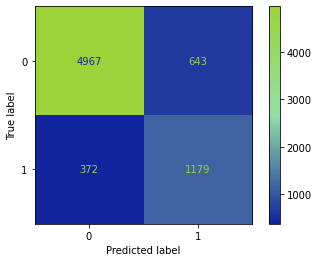

In [36]:
arvore = DecisionTreeClassifier(random_state=SEED)
arvore.fit(X_balanceado_over, y_balanceado_over)

previsao_arvore = arvore.predict(x_teste)

print(classification_report(y_teste, previsao_arvore))

mapa_calor = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#12239e","#92dfa6","#9cd33b"])

ConfusionMatrixDisplay.from_estimator(arvore, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('over-DecisionTree.jpeg', format='jpeg')
plt.show()

#### GradientBoostingClassifier <hr>

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5610
           1       0.68      0.76      0.72      1551

    accuracy                           0.87      7161
   macro avg       0.81      0.83      0.82      7161
weighted avg       0.88      0.87      0.87      7161



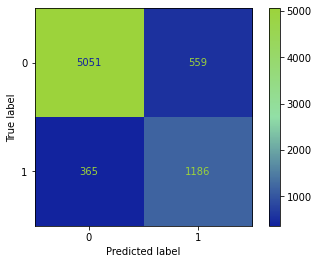

In [37]:
gboost = GradientBoostingClassifier(random_state=SEED)
gboost.fit(X_balanceado_over, y_balanceado_over)
previsao_gboost = gboost.predict(x_teste)

print(classification_report(y_teste, previsao_gboost))

ConfusionMatrixDisplay.from_estimator(gboost, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('over-GradientBoosting.jpeg', format='jpeg')
plt.show()

#### LogisticRegression <hr>

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      5610
           1       0.50      0.75      0.60      1551

    accuracy                           0.78      7161
   macro avg       0.71      0.77      0.72      7161
weighted avg       0.83      0.78      0.79      7161



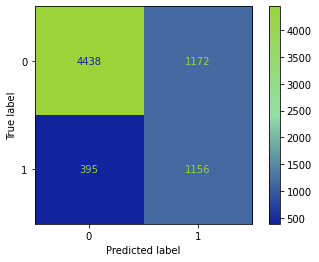

In [38]:
reg_logistica = LogisticRegression(random_state=SEED, max_iter =1000)
reg_logistica.fit(X_balanceado_over, y_balanceado_over)
previsao_reglog = reg_logistica.predict(x_teste)

print(classification_report(y_teste, previsao_reglog))

ConfusionMatrixDisplay.from_estimator(reg_logistica, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('over-LogisticRegression.jpeg', format='jpeg')
plt.show()

Os resultados dos modelos utilizando a técnica de oversampling foram salvos para posterior comparação com a técnica de undersampling.

In [39]:
from sklearn.metrics import recall_score
metricas_over = pd.DataFrame({
            'Acurácia treino':[ arvore.score(x_treino, y_treino), 
                                gboost.score(x_treino, y_treino), 
                                reg_logistica.score(x_treino, y_treino)], 
            'Acurácia teste': [ arvore.score(x_teste, y_teste), 
                                gboost.score(x_teste, y_teste), 
                                reg_logistica.score(x_teste, y_teste)], 
            'Recall':[  recall_score(y_teste, previsao_arvore),
                        recall_score(y_teste, previsao_gboost),
                        recall_score(y_teste, previsao_reglog)]},
             index = ['Árvore de Decisão Oversampling', 'Gradient Boosting Oversampling', 'Regressão Logísitica Oversampling'])

In [40]:
metricas_over

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Oversampling,1.000000,0.858260,0.760155
Gradient Boosting Oversampling,0.876816,0.870968,0.764668
Regressão Logísitica Oversampling,0.778119,0.781176,0.745326


### Aprendizado Undersampling <hr>

Agora será realizado o balanceamento da variável alvo utilizando a técnica de undersampling, que removerá aleatoriamente registros da classe mais frequente, igualando a quantidade de registros das duas classes.

In [41]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(random_state=SEED,sampling_strategy=0.5)
X_balanceado_under, y_balanceado_under = under.fit_resample(x_treino, y_treino)
X_balanceado_under

,onehotencoder__situacao_moradia_Alugada,onehotencoder__situacao_moradia_Hipotecada,onehotencoder__situacao_moradia_Outro,onehotencoder__situacao_moradia_Própria,onehotencoder__motivo_emprestimo_Educativo,onehotencoder__motivo_emprestimo_Empreendimento,onehotencoder__motivo_emprestimo_Melhora do lar,onehotencoder__motivo_emprestimo_Médico,onehotencoder__motivo_emprestimo_Pagamento de débitos,onehotencoder__motivo_emprestimo_Pessoal,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.031250,0.020140,0.121951,0.185714,0.293820,0.0,0.071429
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.156250,0.025052,0.341463,0.451429,0.522472,0.0,0.250000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.031250,0.016701,0.097561,0.514286,0.195506,0.0,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.203125,0.058454,0.121951,0.342857,0.360112,0.0,0.178571
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.171875,0.037234,0.073171,0.142857,0.083708,0.0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13948,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.031250,0.007466,0.073171,0.142857,0.556742,0.0,0.035714
13949,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.171875,0.036499,0.195122,0.285714,0.515169,1.0,0.178571
13950,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.078125,0.022596,0.243902,0.571429,0.116292,0.0,0.035714
13951,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.046875,0.020140,0.146341,0.142857,0.298876,0.0,0.000000


#### DecisionTreeClassifier <hr>

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      5610
           1       0.62      0.77      0.69      1551

    accuracy                           0.85      7161
   macro avg       0.78      0.82      0.79      7161
weighted avg       0.86      0.85      0.85      7161



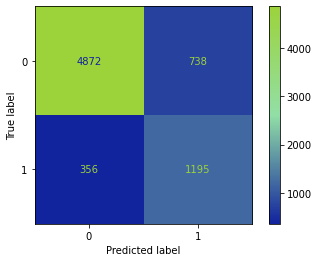

In [42]:
arvore = DecisionTreeClassifier(random_state=SEED)
arvore.fit(X_balanceado_under, y_balanceado_under)
previsao_arvore = arvore.predict(x_teste)

print(classification_report(y_teste, previsao_arvore))

ConfusionMatrixDisplay.from_estimator(arvore, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('under-DecisionTree.jpeg', format='jpeg')
plt.show()

#### GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5610
           1       0.79      0.74      0.76      1551

    accuracy                           0.90      7161
   macro avg       0.86      0.84      0.85      7161
weighted avg       0.90      0.90      0.90      7161



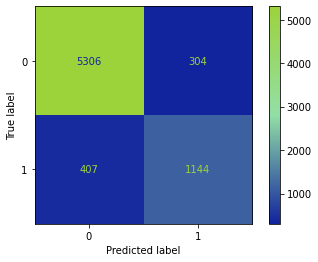

In [43]:
gboost = GradientBoostingClassifier(random_state=SEED)
gboost.fit(X_balanceado_under, y_balanceado_under)
previsao_gboost = gboost.predict(x_teste)

print(classification_report(y_teste, previsao_gboost))

ConfusionMatrixDisplay.from_estimator(gboost, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('under-GradientBoosting.jpeg', format='jpeg')
plt.show()

#### LogisticRegression <hr>

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5610
           1       0.67      0.52      0.59      1551

    accuracy                           0.84      7161
   macro avg       0.77      0.72      0.74      7161
weighted avg       0.83      0.84      0.83      7161



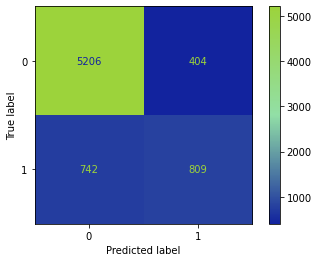

In [44]:
reg_logistica = LogisticRegression(random_state=SEED, max_iter =1000)
reg_logistica.fit(X_balanceado_under, y_balanceado_under)
previsao_reglog = reg_logistica.predict(x_teste)

print(classification_report(y_teste, previsao_reglog))

ConfusionMatrixDisplay.from_estimator(reg_logistica, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('under-LogisticRegression.jpeg', format='jpeg')
plt.show()

Os resultados dos modelos utilizando a técnica de undersampling serão sys para posterior comparação com a técnica de oversampling.

In [45]:
metricas_under = pd.DataFrame({
            'Acurácia treino':[ arvore.score(x_treino, y_treino), 
                                gboost.score(x_treino, y_treino), 
                                reg_logistica.score(x_treino, y_treino)], 
            'Acurácia teste': [ arvore.score(x_teste, y_teste), 
                                gboost.score(x_teste, y_teste), 
                                reg_logistica.score(x_teste, y_teste)], 
            'Recall':[  recall_score(y_teste, previsao_arvore),
                        recall_score(y_teste, previsao_gboost),
                        recall_score(y_teste, previsao_reglog)]},
             index = ['Árvore de Decisão Undersampling', 'Gradient Boosting Undersampling', 'Regressão Logísitica Undersampling'])

In [46]:
metricas_under

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Undersampling,0.954609,0.847228,0.770471
Gradient Boosting Undersampling,0.905633,0.900712,0.737589
Regressão Logísitica Undersampling,0.836825,0.839966,0.521599


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Comparando Samplings</h1>

In [47]:
display(metricas_over,metricas_under)

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Oversampling,1.000000,0.858260,0.760155
Gradient Boosting Oversampling,0.876816,0.870968,0.764668
Regressão Logísitica Oversampling,0.778119,0.781176,0.745326


,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Undersampling,0.954609,0.847228,0.770471
Gradient Boosting Undersampling,0.905633,0.900712,0.737589
Regressão Logísitica Undersampling,0.836825,0.839966,0.521599


Analisando as tabelas, foi possível tirar as seguintes conclusões:

* A regressão logística apresenta um baixo desempenho em relação aos demais modelos, tanto no oversampling quanto undersampling.
* A árvore de decisão apresenta overfitting tanto no oversampling quanto undersampling. Isso ocorre quando desempenho é alto em dados de treino mas não generaliza bem para os dados de teste.
* O gradient boosting foi o modelo mais consistente, não apresentando overfiting.

Vamos analisar as matrizes de confusão do Gradient Boosting usando as técnicas de oversampling e undersampling:



- Oversampling - gradientBoosting

<img src="imagem/over-GradientBoosting.jpeg">

- Undersampling - gradientBoosting

<img src="imagem/under-GradientBoosting.jpeg">

É possível identificar que o modelo de gradient boosting usando técnica oversampling pudermos obter menos erros do que o modelo que usa a técnica de undersampling.

Apesar de o recall do modelo que usa o undersampling ser melhor, ocasiona em um erro muito maior para os clientes não inadimplentes em relação ao modelo que usa o oversampling, o que pode gerar uma insatisfação muito grande nos clientes e perder grande parte do potencial de lucro da empresa.

O modelo escolhido foi o Gradient Boosting usando a técnica de oversampling.

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Otimização de hiperparâmetros</h1>

Vamos passar agora para a otimização de hiperparâmetros do modelo selecionado com o GridSearch.

In [48]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Parâmetros a serem testados:

parameters = {
    "loss":["deviance"],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "absolute_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9],
    "n_estimators":[10,100]
    }

grid_search = GridSearchCV(
                    GradientBoostingClassifier(random_state = SEED),
                    parameters,
                    scoring= 'recall',
                    cv= 3,
                    verbose= 1)

grid_search.fit(X_balanceado_over, y_balanceado_over)
grid_search.cv_results_

previsao_grid_search = grid_search.best_estimator_
previsao_grid = previsao_grid_search.predict(x_teste)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new param

In [49]:
grid_search.cv_results_

{'mean_fit_time': array([1.24665419e-01, 1.55002356e-01, 1.30334059e-01, 1.34000699e-01,
        1.31665230e-01, 1.03299753e+00, 1.12099544e+00, 1.13766742e+00,
        1.14499974e+00, 1.17066367e+00, 1.20336135e-01, 1.21999741e-01,
        1.27000968e-01, 1.28999949e-01, 1.29669348e-01, 1.00866477e+00,
        1.07133603e+00, 1.12966545e+00, 1.13800176e+00, 1.16566690e+00,
        1.55000607e-01, 1.69334491e-01, 1.79663340e-01, 1.84004466e-01,
        1.88331445e-01, 1.44666799e+00, 1.55066562e+00, 1.68300319e+00,
        1.71999756e+00, 1.78899980e+00, 1.54998302e-01, 1.67332888e-01,
        1.80335045e-01, 1.82998419e-01, 1.87662601e-01, 1.45133193e+00,
        1.54733451e+00, 1.73466571e+00, 1.85366758e+00, 1.96266500e+00,
        3.69001150e-01, 3.83666277e-01, 4.42666769e-01, 4.90999937e-01,
        4.24001217e-01, 3.45100117e+00, 3.37874858e+00, 3.77400295e+00,
        3.78066635e+00, 3.76633485e+00, 3.35666656e-01, 3.55665366e-01,
        3.74667962e-01, 3.83663098e-01, 3.91666

In [50]:
previsao_grid_search = grid_search.best_estimator_
previsao_grid = previsao_grid_search.predict(x_teste)

Retornando o melhor estimador encontrado pelo Grid Search:

In [51]:
grid_search.best_estimator_

GradientBoostingClassifier(loss='deviance', max_depth=8, max_features='log2',
                           random_state=144, subsample=0.8)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5610
           1       0.84      0.74      0.79      1551

    accuracy                           0.91      7161
   macro avg       0.89      0.85      0.87      7161
weighted avg       0.91      0.91      0.91      7161



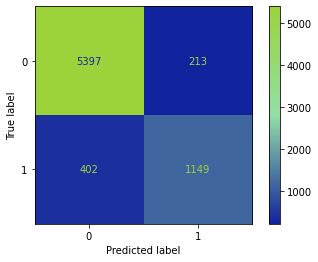

In [58]:
print(classification_report(y_teste, previsao_grid))

ConfusionMatrixDisplay.from_estimator(previsao_grid_search, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('ConfusionMatrix.jpeg', format='jpeg')
plt.show()

Através do resultado, podemos verificar que o desempenho aumentou, principalmente entre os clientes não inadimplentes e esse será o modelo que será colocado em produção.

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Resumo</h1>

* Como o dataset utilizado foi tratado dentro do SQL, os dados vieram limpos sendo necessários somente realizar alguns tratamentos previos.

* Assim, iniciamos esse projeto coletando os dados da semana 1 e realizando uma análise focada no tratamento de dados para serem inseridos em um modelo de ML. Desse modo, foi removido os valores nulos e outliers presentes nos dados, bem como aplicamos o balanceamento, normalização e enconding para tratar o conjunto de dados.

* Assim, construimos três modelos de aprendizado de máquina pensando na explicabilidade do resultado final, comparamos o desempenho deles para o projeto e escolhemos o que teve melhor performance. Com isso, buscamos melhorar ainda mais o resultado final do modelo com uma otimização de hiperparâmetros e, assim que obtivemos um bom produto final, salvamos o modelo fazendo sua exportação.

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Exportando modelos</h1>

Iremos exportar os modelos para que possam ser utilizados futuramente fora do ambiente do Google Colaboratory

In [54]:
import pickle

* Modelo one hot encoder:

In [55]:
with open('one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(one_hot_enc, file)

* Modelo de normalização dos dados:

In [56]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

* Modelo do gradient boosting do grid search:

In [57]:
with open('modelo_treinado.pkl', 'wb') as file:
    pickle.dump(previsao_grid_search, file)

# <h1 style="padding:20px; background-color:#0f4c5c; margin:0; color:white; font-family:newtimeroman; font-size:200%; text-align:center;border-radius: 25px 25px; overflow:hidden; font-weight:500">The End<br></h1>